In [19]:
import glob
from datetime import datetime
import os
from multiprocessing import Pool

import numpy as np
from scipy.ndimage import gaussian_filter

from uncertainty import ComputeSicUncertainty

%matplotlib inline

In [20]:
n_steps = 2210  # should be 2210 to cover 6 years

sia_dir = r"D:\SIA_Weddell_Sea"
mesh_dir = f'{sia_dir}/mesh'
unc_dir = f'{sia_dir}/unc'
sid_dir = r"D:\OSI-SAF\Preprocessing_Antarctica"
ifiles = sorted(glob.glob(f'{sid_dir}/20*/ice_drift*npz'))
idates = [datetime.strptime(os.path.basename(ifile).split('-')[-1].split('.')[0], '%Y%m%d%H%M%S')
          for ifile in ifiles]
print(f'Found {len(ifiles)} ice drift files from {idates[0]} to {idates[-1]}')

mesh_init_file = r"D:\mesh_weddel_ease_25km_mmg_40_52.npz"
xc = np.load(mesh_init_file)['xc']
yc = np.load(mesh_init_file)['yc']
mask = np.load(mesh_init_file)['mask']
mask_f = gaussian_filter(mask.astype(float), 1, truncate=1)

Found 365 ice drift files from 2015-01-01 12:00:00 to 2015-12-31 12:00:00


In [21]:
start_indices = [i for i,j in enumerate(idates) if j.year > 2014 and j.month == 2 and j.day == 15]
start_indices

[45]

In [22]:
csu = ComputeSicUncertainty(ifiles, idates, n_steps, mesh_init_file, mesh_dir, unc_dir, xc, yc)
with Pool(2) as p:
    p.map(csu.compute_uncertainty, start_indices)


Uncertainty of the produced sea ice age variable is computed from the uncertainties of the ice age fractions ($C_i$) multiplied by age ($A$) of the fraction: 

$\sigma_{SIA}^2 = \sum{ A_i * \sigma_{C_{iY}}^2 }, i=1..6$,

where $i$ is the index of the sea ice age fraction: $i=1$ for one-year old ice (i.e., $C_{1Y}$), $i=2$ for two-year old ice, etc.

Each ice age fraction is computed from values of MYI advected for various time (see Eq. NNN). Therefore, the uncertainty of each fraction is computed from uncertaimties of advected MYI fields:

$\sigma_{C_{iY}}^2 = \sum{ \sigma_{C_{A,j}}^2 }, j = 1..6$,

where $j$ is the index of the advected MYI field, with $j=1$ being the yongest advected MYI field.

Uncertainty of the FYI is computed using the uncertainty from the satellite SIC observations and the youngest advected MYI field:

$\sigma_{FYI}^2 = \sigma_{C_{OBS}}^2 + \sigma_{C_{A,1}}^2$

Uncertaimty of the advected MYI field is computed from uncertainties of the satellite derived SIC and SID:

$\sigma_{C_{A,j}}^2 = \sigma_{SIC,j}^2 + \sigma_{SID,j}^2$

Both SIC and SID uncertaimties are iteratively accumulated during the advection of the MYI fields. 

The concentration in the advected field is capped by the observed concentration. In other words it is a minimum values of the advected and the observed concentration (see Eq. NNN). Therefore, the uncertainty of the advected field is the uncertainty of the minimal concentration:

$\sigma_{SIC,j,n}^2 = $

$ k_n \left< \sigma_{SIC,j,n-1}^2 \right> \text{, if } SIC_{n-1} < C_{OBS,n}$

$\sigma_{C_{OBS,n}}^2 \text{, otherwise}$

where $n$ denotes the current step, $n-1$ - the previous step, $\left< \right>$ - operation of advection, $k$ - factor for change of area (and, therefore, uncertainty) due to divergence/convergence (see Eq. NNN).


The uncertainty associated with the drift is computed the following way. First, the uncertainty of the smoothed ice drift product ($\sigma_{S}$) is computed using the provided uncertainties of the OSI-SAF SID product ($\sigma_D$):

$\sigma_{S}^2 = \frac{\sum_k^N{\sigma_{D_k}}}{N}$,

where $\sigma_{D_k}$ is the uncertaimty of gridded ice drift in a $k$-th neighbour and $N$ is number of neighbours.

Next, the integrated uncertainty of the ice drift ($\sigma_{I}$) is iteratively acumulated with advection:

$\sigma_{I,n}^2 = \left< \sigma_{I,n-1}^2 \right> + \sigma_{S}^2$

After some steps of advection, the integrated uncertainty of sea ice drift defines a radius of a circle, where the advected mesh element could have drifted. This circle may include other advected elements with their respective concentrations. Therefore the uncertainty of advected MYI concentration, associated with the uncertaimty of ice drift $\sigma_{SID,j}$ is computed as a standard deviation of concentrations in this circle:

$\sigma_{SID,j}^2 = (\sum_m^M{ C_{A,j,m} - \hat{C}_{A,j})}^2/M$

where $m$ is the index of the elements in the circle, $\hat{C}_{A,j}$ average concentration in the circle, M – number of elements in the circle.


In [23]:
import matplotlib.pyplot as plt

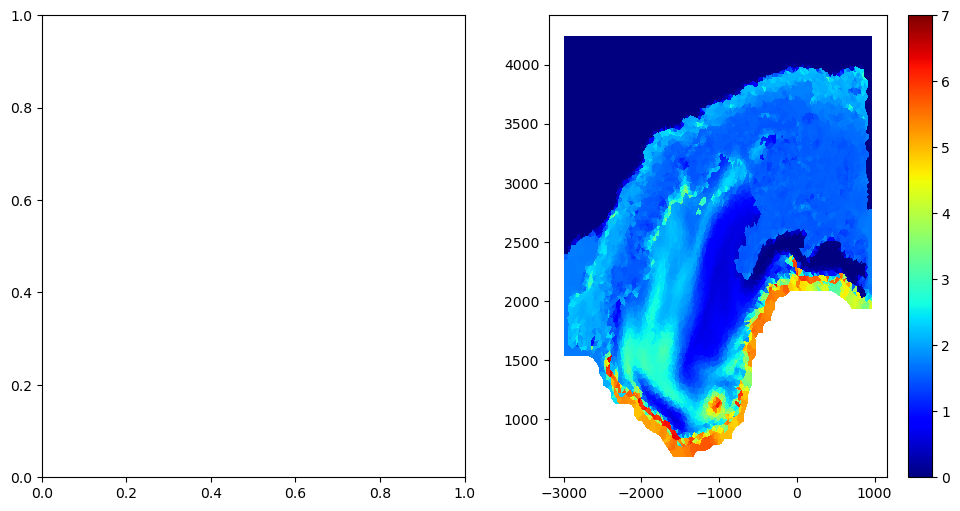

In [24]:
dst_date = '20151231'
#ifile0 = f'data2/Anton/sia/cdr_1991_2023/unc/1991/unc_sic_old/unc_sic_19910905_{dst_date}.npz'
#ifile1 = f'NERSC_arctic25km_sea_ice_age_v2p1/unc/2024/unc_sic_20240905_{dst_date}.npz'
#afile = f'NERSC_arctic25km_sea_ice_age_v2p1/age/{dst_date[:4]}/age_{dst_date}.npz'
ifile1 = f"D:/SIA_Weddell_Sea/unc/2015/unc_sic_20150215_{dst_date}.npz"
afile = f"D:/SIA_Weddell_Sea/age/{dst_date[:4]}/age_{dst_date}.npz"
#ifile1 = f"D:/mesh_output/unc/2015/unc_sic_20150215_{dst_date}.npz"
#afile = f'NERSC_arctic25km_sea_ice_age_v2p1/age/{dst_date[:4]}/age_{dst_date}.npz'
#afile = f"D:/mesh_output/age/{dst_date[:4]}/age_{dst_date}.npz"

with np.load(afile) as f:
    x = f['x']
    y = f['y']
    t = f['t']

#with np.load(ifile0) as f:
#    unc_sic0 = f['unc_sic']

with np.load(ifile1) as f:
    unc_sic1 = f['unc_sic']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#axs[0].tripcolor(x, y, t, unc_sic0, cmap='jet', clim=[0, 7])
plot = axs[1].tripcolor(x, y, t, unc_sic1, cmap='jet', clim=[0, 7])
fig.colorbar(plot, ax=axs[1])
plt.show()
